In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, abspath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.insert(0, abspath("./../../"))

In [4]:
from utils.pandas import apply_filters
from utils_local import colors_v1

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load result file

In [6]:
# csv_path = "../../results/sslvr-action_classification_dataset_size_241221.csv"
csv_path = "../../results/dataset_size_150122.csv"

In [7]:
df = pd.read_csv(csv_path)
df.dropna(inplace=True)

In [8]:
dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

In [9]:
for d, v in dataset_full_size.items():
    indices = (df.Dataset == d) * (df["Dataset size"] == "Full")
    df.at[indices, "Dataset size (float)"] = v

In [10]:
df["Dataset size (float)"] = df["Dataset size (float)"].astype(float)

In [11]:
df

,Method,Dataset,Dataset size,Top-1,Dataset size (float)
0,No pretraining,UCF,1000,43.14,NaN
1,SELAVI,UCF,1000,69.18,NaN
2,RSPNET,UCF,1000,75.68,NaN
3,Video Moco,UCF,1000,65.82,NaN
4,Pretext-Contrast,UCF,1000,62.70,NaN
...,...,...,...,...,...
275,CTP,SS,Full,60.16,169000.0
276,TCLR,SS,Full,59.64,169000.0
277,GDT,SS,Full,57.78,169000.0
278,AVID-CMA,SS,Full,53.82,169000.0


### Consider a single dataset

In [12]:
D = apply_filters(df, {"Dataset": "UCF"})

In [13]:
indices_with_nan = D["Dataset size (float)"].isna()
D.at[indices_with_nan, "Dataset size (float)"] = D[indices_with_nan]["Dataset size"]
D["Dataset size (float)"] = D["Dataset size (float)"].astype(float)

In [14]:
DM = apply_filters(D, {"Method": "Supervised pretraining"})

In [15]:
DM

,Method,Dataset,Dataset size,Top-1,Dataset size (float)
9,Supervised pretraining,UCF,1000,86.02,1000.0
20,Supervised pretraining,UCF,2000,88.98,2000.0
31,Supervised pretraining,UCF,4000,92.55,4000.0
42,Supervised pretraining,UCF,8000,93.47,8000.0
53,Supervised pretraining,UCF,Full,94.08,9500.0


In [16]:
DM["Dataset size (float)"].astype(float)

9     1000.0
20    2000.0
31    4000.0
42    8000.0
53    9500.0
Name: Dataset size (float), dtype: float64

In [17]:
V = DM["Dataset size (float)"].astype(float)

In [18]:
np.append(V, [0])

array([1000., 2000., 4000., 8000., 9500.,    0.])

In [19]:
# fit a 2-degree polynomial

def fit_quadriatic_with_origin(x, y):
    assert isinstance(x, np.ndarray)
    assert isinstance(y, np.ndarray)
    assert len(x) == len(y)
    assert len(x.shape) == 1
    # x = np.append(x, [0.])
    # y = np.append(x, [0.])

    return np.polyfit(x=y, y=y, deg=2)

In [20]:
theta = np.polyfit(x=DM["Dataset size (float)"].values, y=DM["Top-1"].values, deg=2)

In [21]:
theta

array([-1.94726383e-07,  2.88699373e-03,  8.36988905e+01])

Try the same for other methods and visualize learnt parameters

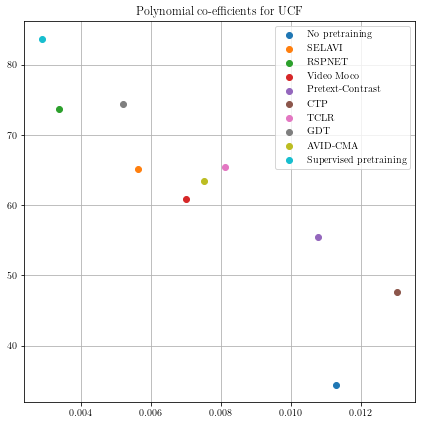

In [22]:
methods = D.Method.unique()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.grid()
ax.set_title("Polynomial co-efficients for UCF")

for m in methods:
    DM = apply_filters(D, {"Method": m})
    theta = np.polyfit(x=DM["Dataset size (float)"].values, y=DM["Top-1"].values, deg=2)
    ax.scatter(theta[1], theta[2], label=m)

ax.legend()
plt.show()

### Extend the same for multiple datasets

In [24]:
from utils_local import colors_v1

In [26]:
len(colors_v1)

10

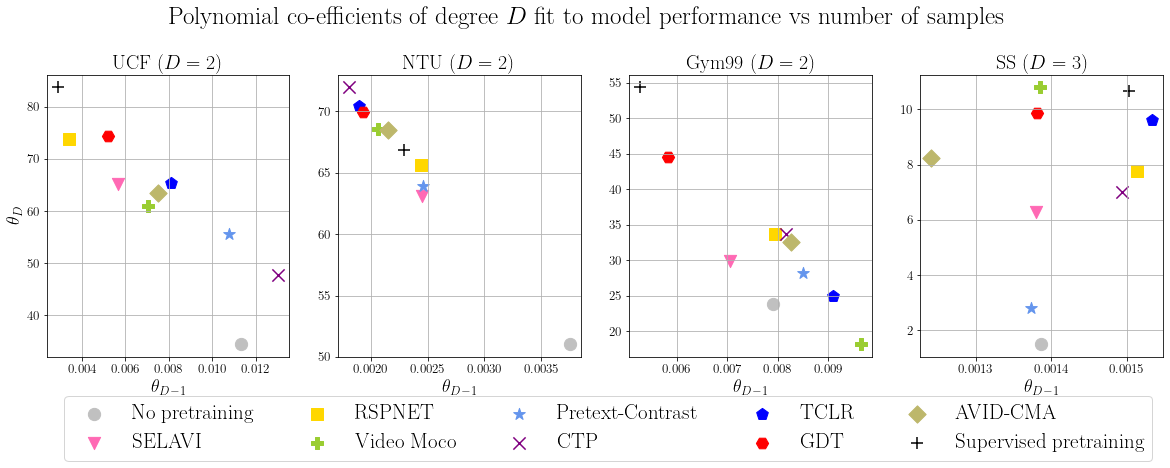

In [45]:
datasets = df.Dataset.unique()

markers = ["o", "v", "s", "P", "*", "x", "p", "H", "D", "+"]

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5.2))

for i, d in enumerate(datasets):
    D = apply_filters(df, {"Dataset": d})
    ax = axes[i]
    
    indices_with_nan = D["Dataset size (float)"].isna()
    D.at[indices_with_nan, "Dataset size (float)"] = D[indices_with_nan]["Dataset size"]
    D["Dataset size (float)"] = D["Dataset size (float)"].astype(float)

    methods = D.Method.unique()

    ax.grid()
    
    deg = 2
    if d == "SS":
        deg = 3
    ax.set_title(f"{d} ($D={deg}$)", fontsize=20)

    for j, m in enumerate(methods):
        DM = apply_filters(D, {"Method": m})
        theta = np.polyfit(x=DM["Dataset size (float)"].values, y=DM["Top-1"].values, deg=deg)
        if d != "SS":
            ax.scatter(theta[1], theta[2], label=m, s=150, marker=markers[j], color=colors_v1[j])
        else:
            ax.scatter(theta[2], theta[3], label=m, s=150, marker=markers[j], color=colors_v1[j])
    
    if i == len(datasets) - 1:
        ax.legend(ncol=len(methods) // 2, bbox_to_anchor=(1.0,-0.1), fontsize=21)
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_xlabel("$\\theta_{D-1}$", fontsize=18)
    if i == 0:
        ax.set_ylabel("$\\theta_{D}$", fontsize=18)

plt.suptitle("Polynomial co-efficients of degree $D$ fit to model performance vs number of samples", fontsize=25, y=1.06)
plt.savefig("../../results/plots/dataset_size_ablation_poly_fit.pdf", bbox_inches="tight")
plt.show()